[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
2/2 [==============================] - 6s 1s/step - loss: 1976.1627 - price_output_loss: 1975.4696 - increase_output_loss: 0.6931 - increase_output_accuracy: 0.4911 - val_loss: 2283.7810 - val_price_output_loss: 2283.0874 - val_increase_output_loss: 0.6935 - val_increase_output_accuracy: 0.4643
Epoch 2/50
2/2 [==============================] - 0s 225ms/step - loss: 1938.0668 - price_output_loss: 1937.3788 - increase_output_loss: 0.6881 - increase_output_accuracy: 0.5536 - val_loss: 2230.3513 - val_price_output_loss: 2229.6580 - val_increase_output_loss: 0.6933 - val_increase_output_accuracy: 0.4643
Epoch 3/50
2/2 [==============================] - 0s 253ms/step - loss: 1892.6038 - price_output_loss: 1891.9121 - increase_output_loss: 0.6916 - increase_output_accuracy: 0.6071 - val_loss: 2162.9070 - val_price_output_loss: 2162.2151 - val_increase_output_loss: 0.6919 - val_increase_output_accuracy: 0.5357
Epoch 4/50
2/2 [==============================] - 0s 246ms/step - loss: 1

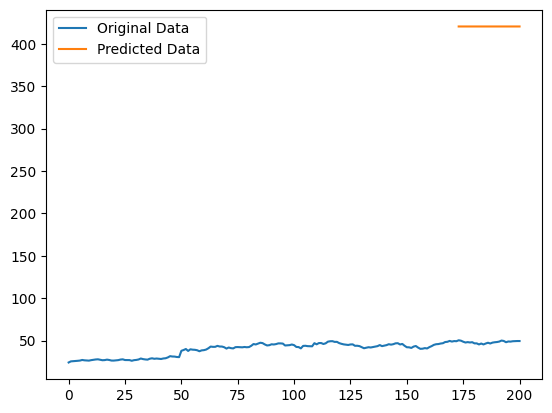

1/1 [==============================] - 0s 30ms/step
Predicted Opening and Closing Prices for 2023-12-30: Open: 420.50, Close: 420.50
Will the price increase? Yes


In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta
import pandas_datareader as pdr

# Download stock data
stock_data = yf.download('NVDA', start='2023-01-01', end='2024-07-15')

# Reset index to make 'Date' a column
stock_data.reset_index(inplace=True)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Add earnings reports data
nvda = yf.Ticker('NVDA')
earnings = nvda.earnings_dates.reset_index()
# Rename the correct column to 'Date' (Assuming the old index is in column 0)
earnings.rename(columns={earnings.columns[0]: "Date"}, inplace=True)
earnings['Date'] = pd.to_datetime(earnings['Date'])

# Ensure both 'Date' columns have the same datetime type (naive datetime64[ns])
stock_data['Date'] = stock_data['Date'].dt.tz_localize(None)
earnings['Date'] = earnings['Date'].dt.tz_localize(None)

# Merge stock data with earnings data
stock_data = stock_data.merge(earnings[['Date']], how='left', on='Date')
stock_data['Earnings'] = stock_data['Date'].isin(earnings['Date']).astype(int)

# Add economic indicators data: GDP
gdp_data = pdr.get_data_fred('GDP', start=datetime(2023, 1, 1), end=datetime(2024, 7, 1))
gdp_data.rename(columns={"GDP": "GDP_Quarterly"}, inplace=True)
gdp_data = gdp_data.resample('D').ffill().reset_index()  # Fill daily with forward fill
gdp_data.rename(columns={"DATE": "Date"}, inplace=True)
gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])

# Merge GDP data with stock data
stock_data = stock_data.merge(gdp_data, how='left', on='Date')

# Set the index back to 'Date'
stock_data.set_index('Date', inplace=True)

# Create additional features
stock_data['MA_20'] = stock_data['Close'].rolling(window=20).mean()  # 20-day moving average
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()  # 50-day moving average

# Create a binary target variable for price increase
stock_data['Price_Increase'] = (stock_data['Close'].shift(-1) > stock_data['Close']).astype(int)
stock_data.dropna(inplace=True)  # Drop NaN values created by moving averages and Price_Increase

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[['Close', 'Open', 'High', 'Low', 'Volume', 'MA_20', 'MA_50', 'Earnings', 'GDP_Quarterly']].values)

# Create dataset
def create_dataset(data, target_price, target_increase, time_step):
    X, y_price, y_increase = [], [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y_price.append(target_price[i + time_step])
        y_increase.append(target_increase[i + time_step])
    return np.array(X), np.array(y_price), np.array(y_increase)

time_step = 60
X, y_price, y_increase = create_dataset(scaled_data, stock_data['Close'].values, stock_data['Price_Increase'].values, time_step)

# Check if the dataset is empty
if X.size == 0 or y_price.size == 0 or y_increase.size == 0:
    raise ValueError("Not enough data to create the dataset with the given time_step. Please use a smaller time_step.")

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_price_train, y_price_test = y_price[:train_size], y_price[train_size:]
y_increase_train, y_increase_test = y_increase[:train_size], y_increase[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))

# Separate output layers for price prediction and increase prediction
price_output = Dense(1, name='price_output')(model.output)
increase_output = Dense(1, activation='sigmoid', name='increase_output')(model.output)

# Build and compile the model
model = Model(inputs=model.input, outputs=[price_output, increase_output])
model.compile(optimizer='adam', loss={'price_output': 'mean_squared_error', 'increase_output': 'binary_crossentropy'}, metrics={'increase_output': 'accuracy'})

# Fit the model
model.fit(X_train, {'price_output': y_price_train, 'increase_output': y_increase_train}, epochs=50, batch_size=64, validation_data=(X_test, {'price_output': y_price_test, 'increase_output': y_increase_test}))

# Evaluate the model
test_results = model.evaluate(X_test, {'price_output': y_price_test, 'increase_output': y_increase_test})

# Unpack the results (adjust indices as needed based on your model's output)
test_loss = test_results[0]  # Overall loss
test_price_loss = test_results[1]  # Loss for price prediction
test_increase_loss = test_results[2] # Loss for increase prediction
test_increase_acc = test_results[3]  # Accuracy for increase prediction

print('Test Loss:', test_loss)
print('Test Price Loss:', test_price_loss)
print('Test Increase Loss:', test_increase_loss)
print('Test Increase Accuracy:', test_increase_acc)

# Predict the test data
predictions = model.predict(X_test)
predictions_price = scaler.inverse_transform(np.concatenate((predictions[0], np.zeros((predictions[0].shape[0], 8))), axis=1))[:, 0]
predictions_increase = (predictions[1] > 0.5).astype(int)

# Plot the original and predicted data
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(predictions_price):] = predictions_price

plt.plot(original_data, label='Original Data')
plt.plot(predicted_data, label='Predicted Data')
plt.legend()
plt.show()

# Predict the next day's stock price and whether it will increase
X_input = scaled_data[-time_step:].reshape(1, time_step, X.shape[2])
next_day_predictions = model.predict(X_input)
next_day_price = scaler.inverse_transform(np.concatenate((next_day_predictions[0], np.zeros((1, 8))), axis=1))[:, 0]
next_day_increase = (next_day_predictions[1] > 0.5).astype(int)

# Print the predicted opening and closing prices for the next day
last_date = stock_data.index[-1]
next_date = last_date + timedelta(days=1)
print(f"Predicted Opening and Closing Prices for {next_date.date()}: Open: {next_day_price[0]:.2f}, Close: {next_day_price[0]:.2f}")
print(f"Will the price increase? {'Yes' if next_day_increase[0] else 'No'}")
